# Modeling - Light Gradient Boosting Machine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
import lightgbm as lgb
import os 
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
df_train = pd.read_pickle("feature_engineering_train_dataset.pkl")
df_valid = pd.read_pickle("feature_engineering_validation_dataset.pkl")

In [3]:
display(df_train.head(3))
print("Shape: ", df_train.shape)

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wcovid_vaccinated_or_accept,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,...,dummy_south_dakota,dummy_tennessee,dummy_texas,dummy_utah,dummy_vermont,dummy_virginia,dummy_washington,dummy_west_virginia,dummy_wisconsin,dummy_wyoming
0,2021-01-12,10001,27.626437,29.695810,2.245193,61.460460,59.611104,28.867446,45.176114,37.305956,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-13,10001,29.008665,26.041461,2.355360,64.432266,56.863993,29.842478,45.557870,39.091765,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-14,10001,29.180034,26.490986,1.905282,68.381496,64.845904,34.533212,47.707745,37.870228,...,0,0,0,0,0,0,0,0,0,0


Shape:  (8038, 105)


In [4]:
display(df_valid.head(3))
print("Shape: ", df_valid.shape)

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wcovid_vaccinated_or_accept,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,...,dummy_south_dakota,dummy_tennessee,dummy_texas,dummy_utah,dummy_vermont,dummy_virginia,dummy_washington,dummy_west_virginia,dummy_wisconsin,dummy_wyoming
0,2021-02-02,10001,32.242002,16.735176,3.854930,65.747872,67.494766,22.045415,66.438259,44.750377,...,0,0,0,0,0,0,0,0,0,0
1,2021-02-03,10001,34.991057,18.797872,9.298927,66.752089,64.805847,26.106294,63.255370,46.075447,...,0,0,0,0,0,0,0,0,0,0
2,2021-02-04,10001,31.996321,17.816678,8.826546,69.706913,64.414916,26.765270,63.628774,46.781418,...,0,0,0,0,0,0,0,0,0,0


Shape:  (1717, 105)


In [5]:
# Feature Selection: 
# Drop smoothed_wvaccine_likely_who since we already have smoothed_wvaccine_likely_govt_health
# Drop smoothed_wwearing_mask since we already have smoothed_wothers_masked 
# Drop smoothed_wcovid_vaccinated_or_accept since it states that espondents who either have already received a COVID vaccine or would definitely or probably choose to get vaccinated
list_drop_cols = ['smoothed_wvaccine_likely_who','smoothed_wwearing_mask','smoothed_wcovid_vaccinated_or_accept'
                  ,'smoothed_wvaccine_likely_who_rolling_mean_3','smoothed_wwearing_mask_rolling_mean_3','smoothed_wcovid_vaccinated_or_accept_rolling_mean_3'
                  ,'smoothed_wvaccine_likely_who_lag_3','smoothed_wwearing_mask_lag_3','smoothed_wcovid_vaccinated_or_accept_lag_3'
                  ]

In [6]:
df_train = df_train.drop(columns = list_drop_cols)
df_valid = df_valid.drop(columns = list_drop_cols)

In [7]:
print("Shape: ", df_train.shape)
print("Shape: ", df_valid.shape)

Shape:  (8038, 96)
Shape:  (1717, 96)


In [8]:
target_var = 'smoothed_wcovid_vaccinated'
list_features = [col for col in df_train.columns if col not in ["time_value",'geo_value','state','county_name'
                                                                ,'day_of_week','day','week_of_month',target_var]]

In [9]:
list_scale = [col for col in list_features if 'dummy' not in col]
list_scale[-5:]

['smoothed_wcli_lag_3_x_smoothed_wwork_outside_home_1d',
 'smoothed_wothers_masked_x_smoothed_wcovid_vaccinated_or_accept',
 'smoothed_wtested_14d_x_smoothed_wvaccine_likely_govt_health',
 'smoothed_wcli_x_smoothed_wcovid_vaccinated_or_accept',
 'smoothed_wcovid_vaccinated_or_accept_x_smoothed_wvaccine_likely_friends']

In [10]:
# RFE
model = ElasticNet(alpha=0.01, l1_ratio=0.1)
selector = RFE(estimator=model, n_features_to_select=40, step=3)
selector.fit(df_train[list_features], df_train[target_var])

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e+03, tolerance: 1.512e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e+03, tolerance: 1.512e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-p

RFE(estimator=ElasticNet(alpha=0.01, l1_ratio=0.1), n_features_to_select=40,
    step=3)

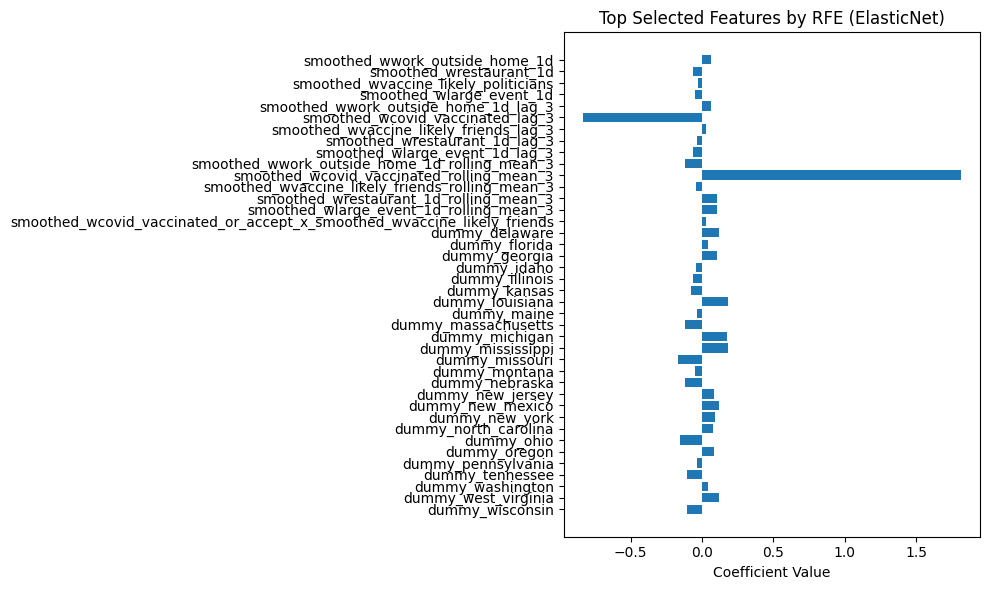

In [11]:
# Get selected features and their coefficients
selected_features = df_train[list_features].columns[selector.support_]
coef = selector.estimator_.coef_

plt.figure(figsize=(10, 6))
plt.barh(selected_features, coef)
plt.xlabel('Coefficient Value')
plt.title('Top Selected Features by RFE (ElasticNet)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
list_time_value = sorted(df_train['time_value'].unique())
list_time_value

[Timestamp('2021-01-10 00:00:00'),
 Timestamp('2021-01-11 00:00:00'),
 Timestamp('2021-01-12 00:00:00'),
 Timestamp('2021-01-13 00:00:00'),
 Timestamp('2021-01-14 00:00:00'),
 Timestamp('2021-01-15 00:00:00'),
 Timestamp('2021-01-16 00:00:00'),
 Timestamp('2021-01-17 00:00:00'),
 Timestamp('2021-01-18 00:00:00'),
 Timestamp('2021-01-19 00:00:00'),
 Timestamp('2021-01-20 00:00:00'),
 Timestamp('2021-01-21 00:00:00'),
 Timestamp('2021-01-22 00:00:00'),
 Timestamp('2021-01-23 00:00:00'),
 Timestamp('2021-01-24 00:00:00'),
 Timestamp('2021-01-25 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-27 00:00:00'),
 Timestamp('2021-01-28 00:00:00'),
 Timestamp('2021-01-29 00:00:00')]

In [13]:
tscv = TimeSeriesSplit(n_splits=3, test_size=3)
for i, (train_index, valid_index) in enumerate(tscv.split(list_time_value)):
    print(f"Fold {i}:")
    print(f"  Train Data    : First Date = {list_time_value[train_index[0]]}, Last Date = {list_time_value[train_index[-1]]}")
    print(f"  Train Shape   :", df_train[(df_train['time_value']>=list_time_value[train_index[0]])&(df_train['time_value']<=list_time_value[train_index[-1]])].shape)
    print(f"  Validation Data     : First Date = {list_time_value[valid_index[0]]}, Last Date = {list_time_value[valid_index[-1]]}")
    print(f"  Validation Shape    :", df_train[(df_train['time_value']>=list_time_value[valid_index[0]])&(df_train['time_value']<=list_time_value[valid_index[-1]])].shape)

Fold 0:
  Train Data    : First Date = 2021-01-10 00:00:00, Last Date = 2021-01-20 00:00:00
  Train Shape   : (4105, 96)
  Validation Data     : First Date = 2021-01-21 00:00:00, Last Date = 2021-01-23 00:00:00
  Validation Shape    : (1311, 96)
Fold 1:
  Train Data    : First Date = 2021-01-10 00:00:00, Last Date = 2021-01-23 00:00:00
  Train Shape   : (5416, 96)
  Validation Data     : First Date = 2021-01-24 00:00:00, Last Date = 2021-01-26 00:00:00
  Validation Shape    : (1311, 96)
Fold 2:
  Train Data    : First Date = 2021-01-10 00:00:00, Last Date = 2021-01-26 00:00:00
  Train Shape   : (6727, 96)
  Validation Data     : First Date = 2021-01-27 00:00:00, Last Date = 2021-01-29 00:00:00
  Validation Shape    : (1311, 96)


In [14]:
df_already_model = pd.read_excel("consolidated_cross_validation_lgbm_model_result.xlsx", sheet_name="consolidated_cross_validation")
tried_params = {tuple(sorted(row.items())) for _, row in df_already_model.drop(columns='rmse').iterrows()}

In [15]:
param_grid = {'learning_rate': [0.03, 0.05, 0.1],
              'num_leaves': [12,15,20,25,30],
              'max_depth': [6,10, 15],
              'lambda_l1': [0.5, 1.0],
              'lambda_l2': [0.5, 1.0],
              'n_estimators': [3000]
              }

param_names = list(param_grid.keys())
param_combine = list(product(*param_grid.values()))

results = {}  # key: params, value: list of fold RMSEs

for values in param_combine:
    params = dict(zip(param_names, values))
    param_key = tuple(sorted(params.items()))

    if param_key in tried_params:
        # Skip the already did parameter set
        continue

    fold_rmse = []
    for i, (train_index, valid_index) in enumerate(tscv.split(list_time_value)):
        start_train, end_train = list_time_value[train_index[0]], list_time_value[train_index[-1]]
        start_val, end_val = list_time_value[valid_index[0]], list_time_value[valid_index[-1]]

        X_tr = df_train[df_train['time_value'].between(start_train, end_train)][selected_features]
        y_tr = df_train[df_train['time_value'].between(start_train, end_train)][target_var]
        X_val = df_train[df_train['time_value'].between(start_val, end_val)][selected_features]
        y_val = df_train[df_train['time_value'].between(start_val, end_val)][target_var]

        model = lgb.LGBMRegressor(
            objective='regression',
            random_state=88,
            n_jobs=-1,
            verbose=-1,
            **params
        )

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=0)
            ]
        )

        preds = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, preds)
        fold_rmse.append(rmse)

    avg_rmse = np.mean(fold_rmse)
    results[tuple(params.items())] = avg_rmse

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[414]	valid_0's rmse: 1.45491	valid_0's l2: 2.11675
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[538]	valid_0's rmse: 1.4533	valid_0's l2: 2.11209
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[341]	valid_0's rmse: 1.57704	valid_0's l2: 2.48706
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[403]	valid_0's rmse: 1.45576	valid_0's l2: 2.11925
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[650]	valid_0's rmse: 1.43609	valid_0's l2: 2.06235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[370]	valid_0's rmse: 1.57283	valid_0's l2: 2.4738
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[306]	valid_0's rm

In [16]:
best_params, best_score = min(results.items(), key=lambda x: x[1])
print(f"Best Params:", dict(best_params))
print(f"Best Avg RMSE: {best_score:.4f}")

Best Params: {'learning_rate': 0.03, 'num_leaves': 12, 'max_depth': 6, 'lambda_l1': 0.5, 'lambda_l2': 1.0, 'n_estimators': 3000}
Best Avg RMSE: 1.4882


In [17]:
df_results = pd.DataFrame([{**dict(k), 'rmse': v} for k, v in results.items()])
df_results.to_csv("cross_validation_lgbm_model_result.csv", index = False)

In [18]:
# Combine best parameters
X_train = df_train[selected_features]
y_train = df_train[target_var]

final_model = lgb.LGBMRegressor(objective='regression',
                                random_state=88,
                                n_jobs=-1,
                                **dict(best_params),
                                verbose=-1
                                )

final_model.fit(X_train, y_train)

LGBMRegressor(lambda_l1=0.5, lambda_l2=1.0, learning_rate=0.03, max_depth=6,
              n_estimators=3000, n_jobs=-1, num_leaves=12,
              objective='regression', random_state=88, verbose=-1)

In [19]:
y_pred = final_model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_pred)
print(f"Train RMSE: {rmse:.4f}")

Train RMSE: 0.6583


In [20]:
X_valid = df_valid[selected_features]
y_valid = df_valid[target_var]

y_pred = final_model.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 1.8199


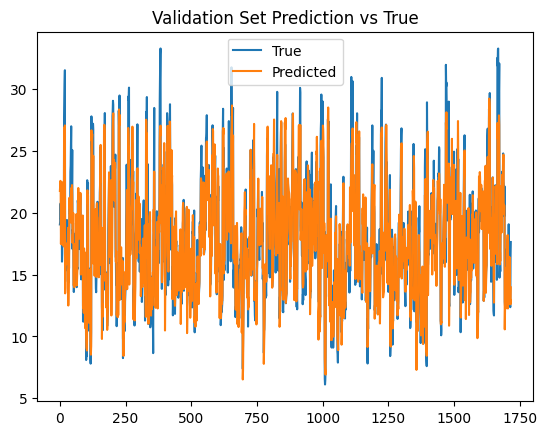

In [21]:
import matplotlib.pyplot as plt

plt.plot(y_valid.values, label="True")
plt.plot(y_pred, label="Predicted")
plt.title("Validation Set Prediction vs True")
plt.legend()
plt.show()

In [23]:
df_test = pd.read_pickle("feature_engineering_test_dataset.pkl")
X_test = df_test[selected_features]
y_test = df_test[target_var]

y_pred = final_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 2.4540
